# Neighbourhood based query to reference distance finder at gene-level

### An embedding alignment approach (i.e. no time series alignment) to find genes with different alignment patterns across time.

This analysis involves 3 main steps:

1. Load anndata reference and query objects with the already QC, preprocessed, and log1p normalized gene expression data, along with relevant integrated latent embedding in the obsm (e.g. X_scVI). 
2. Run **NNDistFinder** to compute a distance matrix based on gene expression distributions of query2reference cell neighbourhoods (A query cells x genes matrix)
3. Compute cell-level distances by averaging across all genes
4. Run Non-negative matrix factorization to identify gene modules which show gene expression changes at different stages of cell differentiation 

**Implemented by:** Dinithi Sumanaweera <br>
**NNDistFinder** module computes distributional distances of gene expression for each query cell 
in terms of its own neighbour cells vs. reference neighbour cells. <br>
Cell neighbourhoods are queried using the data structures available in BBKNN package (https://github.com/Teichlab/bbknn). <br>
**Acknowledgement**: Krzysztof Polanski

This is a supplementary notebook for research poster: "Gene-level alignment of single-cell trajectories" at ISMB 2024 conference. 

In [1]:
import anndata
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import scanpy as sc
import platform
from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix
import time
print(platform.python_version())

3.8.18


## 1. Load data

In [2]:
# load reference and query anndata objects

# example dataset: pan fetal reference and artificial thymic organoid (ATO) datasets
adata_ref = anndata.read_h5ad('adata_ref.h5ad')
adata_query = anndata.read_h5ad('adata_query.h5ad')
c_order = ['IPSC', 'PRIMITIVE_STREAK','MESODERMAL_PROGENITOR', 'ENDOTHELIUM', 'HSC_MPP', 'HSC_MPP/LMPP_MLP/DC2', 'DN(EARLY)_T', 'DN_T', 'DP(P)_T', 'DP(Q)_T', 'ABT(ENTRY)','SP_T']
adata_query.obs['ANNOTATION_COMB'] = pd.Categorical(adata_query.obs['ANNOTATION_COMB'], categories=c_order, ordered=True)

# define cell type annotation obs columan name
ANNOTATION_COLNAME ='ANNOTATION_COMB'

In [3]:
adata_ref

AnnData object with n_obs × n_vars = 20327 × 1371
    obs: 'ANNOTATION_COMB', 'time', 'bbk', 'n_counts', 'refined_time', 'bin_ids'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
adata_query

AnnData object with n_obs × n_vars = 17176 × 1371
    obs: 'ANNOTATION_COMB', 'time', 'n_counts', 'refined_time', 'bin_ids'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

## 2. Run NNDistFinder 

In [6]:
import NNDistFinder

s = time.time()
gene_diff_mat = NNDistFinder.main(adata_ref, adata_query, 'X_scVI', n_neighbours=25)
t = time.time()
print(t-s)

n_neighbours:  25
distance metric:  wasserstein
n_processors:  32
NNDist computation ======


100%|██████████| 17176/17176 [33:13<00:00,  8.61it/s]


Normalizing output ======
2001.8106081485748


In [3]:
import NNDistFinder

s = time.time()
gene_diff_mat = NNDistFinder.main(adata_ref, adata_query, 'X_scVI', n_neighbours=25)
t = time.time()
print(t-s)
# Took 7.2 min for 17176 query cells across 1371 TFs under 60 processes running in parallel. 

n_neighbours:  25
distance metric:  wasserstein
n_processors:  60
NNDist computation ======


100%|██████████| 17176/17176 [07:04<00:00, 40.48it/s]


Normalizing output ======
434.4469892978668


## 3. Check cell-level average distances

In [7]:
# create adata of gene expression distances 
adata_diff = anndata.AnnData(csr_matrix(gene_diff_mat) )
adata_diff.obs_names = list(adata_query.obs_names) 
adata_diff.var_names = adata_query.var_names
adata_diff.obs[ANNOTATION_COLNAME] = adata_query.obs[ANNOTATION_COLNAME]
adata_diff.obsm['X_umap'] = adata_query.obsm['X_umap']
adata_diff.obs['avg_dist'] = np.mean(gene_diff_mat, axis=1) # average distance across all genes
adata_diff.obs['avg_dist'] = pd.DataFrame(adata_diff.obs['avg_dist']).apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0) # min max dist

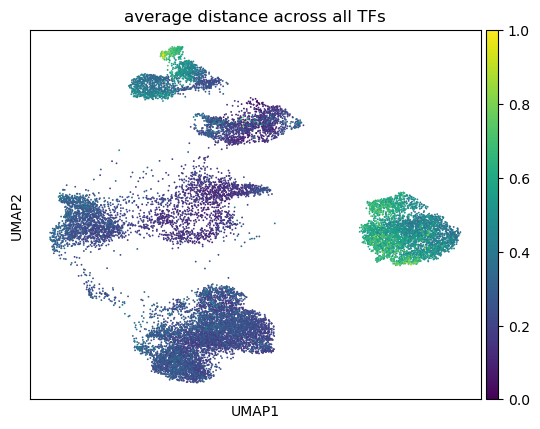

In [5]:
sc.pl.umap(adata_diff, color='avg_dist', title='average distance across all TFs')

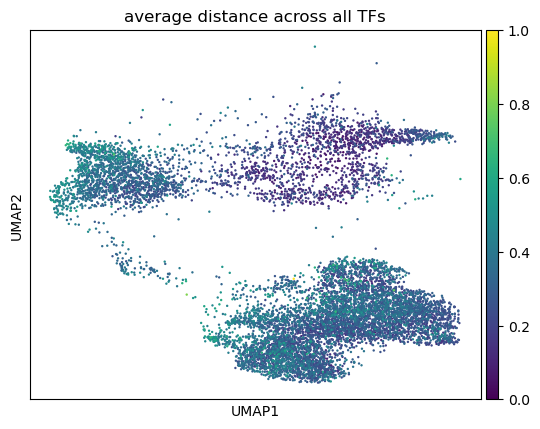

In [9]:
adata_temp = adata_diff[[c not in ['PRIMITIVE_STREAK', 'MESODERMAL_PROGENITOR', 'IPSC','ENDOTHELIUM','HSC_MPP/LMPP_MLP/DC2','HSC_MPP']for c in adata_query.obs['ANNOTATION_COMB']],:]
adata_temp.obs['avg_dist'] = pd.DataFrame(adata_temp.obs['avg_dist']).apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0)
sc.pl.umap(adata_temp, color='avg_dist', title='average distance across all TFs')

## 4. Run NMF and analyse factors for different alignment patterns across differentiation time

In [38]:
def run_NMF(df, k=10):
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(df)
    H = model.components_
    nmf_mat = pd.DataFrame(H).transpose()
    nmf_mat.index = adata_query.var_names
    nmf_mat = nmf_mat.apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0)# min-max normalization
    return nmf_mat 

nmf_mat = run_NMF(gene_diff_mat, k=20)

# Clustering NMF gene x factor matrix

In [39]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=15).fit(nmf_mat)
AgglomerativeClustering()
clustering.labels_
np.unique(clustering.labels_, return_counts=True)
df = nmf_mat.copy()
df['cluster_id'] = clustering.labels_

In [53]:
df

0         1         2         3         4         5  \
AC023509.3  0.000000  0.000000  0.018107  0.020021  0.007989  0.025876   
AC092835.1  0.000000  0.062253  0.025302  0.000795  0.085779  0.037771   
ADNP        0.175099  0.389590  0.197974  0.000000  0.000000  0.144419   
ADNP2       0.109456  0.225080  0.050190  0.093924  0.093567  0.101054   
AEBP1       0.155127  0.150109  0.486501  0.668178  0.168630  0.000000   
...              ...       ...       ...       ...       ...       ...   
ZSCAN5A     0.064707  0.111876  0.100547  0.050720  0.077990  0.057826   
ZSCAN9      0.021755  0.128274  0.189897  0.008703  0.137289  0.121414   
ZXDA        0.003567  0.000000  0.000000  0.000000  0.015834  0.045556   
ZXDB        0.000000  0.059008  0.059126  0.036695  0.046263  0.045590   
ZXDC        0.064550  0.033741  0.266090  0.033366  0.078706  0.204955   

                   6         7         8         9  ...        11        12  \
AC023509.3  0.002670  0.010215  0.004370  0.000000  ...  0.028129  0.008296   
AC092835.1  0.278826  0.031160  0.024590  0.046118  ...  0.025026  0.054489   
ADNP        0.097869  0.000000  0.196956  0.124284  ...  0.001435  0.301211   
ADNP2       0.096036  0.024166  0.125370  0.133741  ...  0.095871  0.199583   
AEBP1       0.111168  0.131325  0.000000  0.090162  ...  0.324004  0.127188   
...              ...       ...       ...       ...  ...       ...       ...   
ZSCAN5A     0.252708  0.092069  0.052884  0.123743  ...  0.013361  0.070026   
ZSCAN9      0.114601  0.024080  0.000000  0.341827  ...  0.164546  0.070166   
ZXDA        0.091189  0.043771  0.015663  0.047612  ...  0.058831  0.029794   
ZXDB        0.059317  0.018273  0.044896  0.057663  ...  0.050648  0.037051   
ZXDC        0.175576  0.123529  0.084107  0.087142  ...  0.032655  0.199918   

                  13        14        15        16        17        18  \
AC023509.3  0.000000  0.067712  0.000000  0.000000  0.020975  0.005460   
AC092835.1  0.140584  0.070864  0.050270  0.151265  0.072942  0.008288   
ADNP        0.099050  0.113230  0.085700  0.171477  0.235344  0.078959   
ADNP2       0.188755  0.141277  0.079325  0.135665  0.110360  0.027728   
AEBP1       0.076412  0.069941  0.284884  0.018440  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
ZSCAN5A     0.040554  0.032298  0.041811  0.000000  0.050676  0.076422   
ZSCAN9      0.096747  0.110555  0.049137  0.045113  0.019165  0.088922   
ZXDA        0.048691  0.008216  0.000000  0.120216  0.109529  0.047284   
ZXDB        0.027154  0.036288  0.000000  0.103233  0.097799  0.032895   
ZXDC        0.017500  0.026612  0.079809  0.110955  0.215173  0.042756   

                  19  cluster_id  
AC023509.3  0.000000          11  
AC092835.1  0.087060          12  
ADNP        0.064630           2  
ADNP2       0.073083           5  
AEBP1       0.027729           6  
...              ...         ...  
ZSCAN5A     0.054333          13  
ZSCAN9      0.090000           0  
ZXDA        0.107999          13  
ZXDB        0.131852          13  
ZXDC        0.048751           0  

[1371 rows x 21 columns]

# A cluster representing differential genes associated with the TNFa signalling pathway

In [54]:
import gseapy as gp
enr = gp.enrichr(gene_list=list(df[df['cluster_id'] == 9].index),
                     gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                     organism='human',
                     outdir=None, background= adata_ref.var_names)
enr.results[enr.results['Adjusted P-value']<0.05][0:5]

Gene_set                             Term       P-value  \
0  MSigDB_Hallmark_2020    TNF-alpha Signaling via NF-kB  1.998098e-12   
1  MSigDB_Hallmark_2020                   UV Response Up  3.225158e-06   
2  MSigDB_Hallmark_2020                          Hypoxia  1.219737e-05   
3  MSigDB_Hallmark_2020                      p53 Pathway  1.223004e-02   
4  MSigDB_Hallmark_2020  Reactive Oxygen Species Pathway  1.743505e-02   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0      2.797337e-11            0                     0  120.545455   
1      2.257611e-05            0                     0   67.450000   
2      5.692108e-05            0                     0   44.800000   
3      4.280512e-02            0                     0   14.900000   
4      4.881815e-02            0                     0  123.454545   

   Combined Score                                         Genes  
0     3247.352977  NR4A2;NR4A1;JUN;KLF6;REL;FOSB;FOS;JUNB;FOSL2  
1      852.873456                           NR4A1;FOSB;FOS;JUNB  
2      506.880189                            JUN;KLF6;FOS;FOSL2  
3       65.617521                                       JUN;FOS  
4      499.901097                                          JUNB

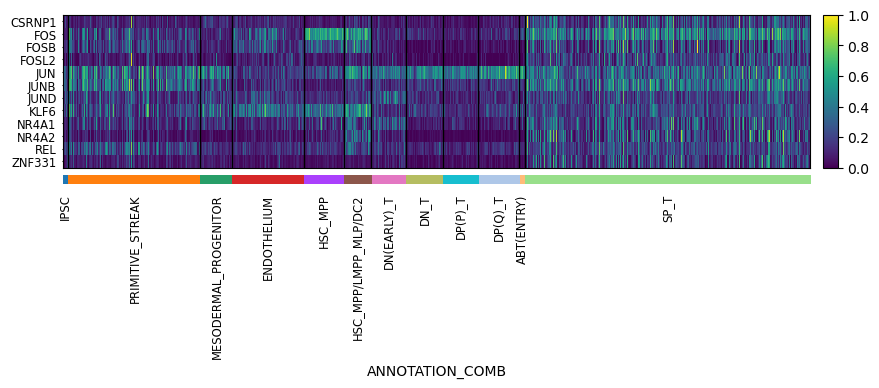

In [52]:
sc.pl.heatmap(adata_diff, list(df[df['cluster_id'] == 9].index), groupby='ANNOTATION_COMB', swap_axes=True, vmin =0)

# Visualising all the identified gene clusters

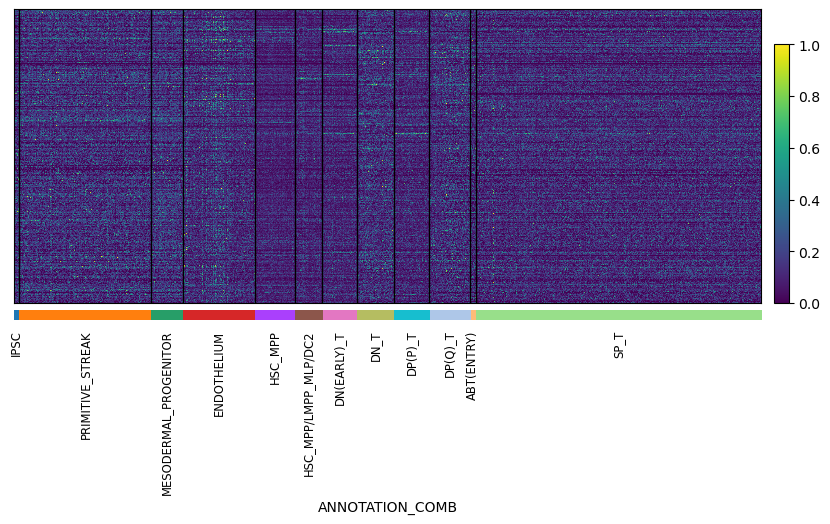

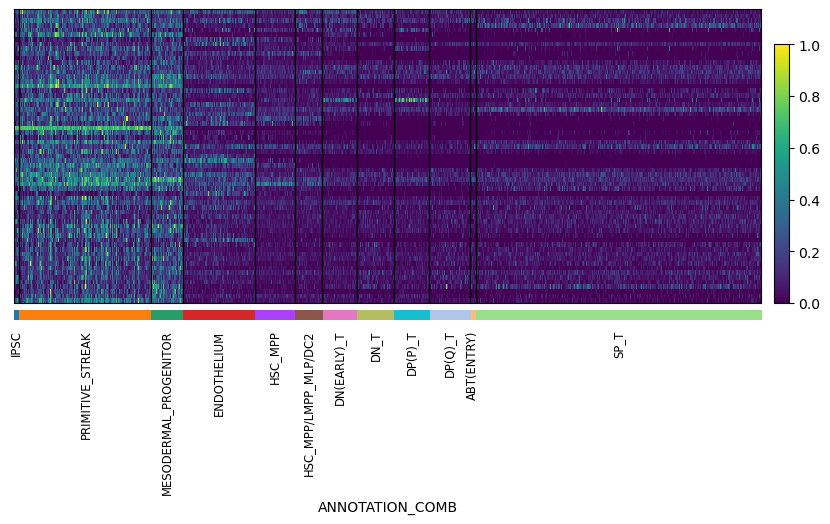

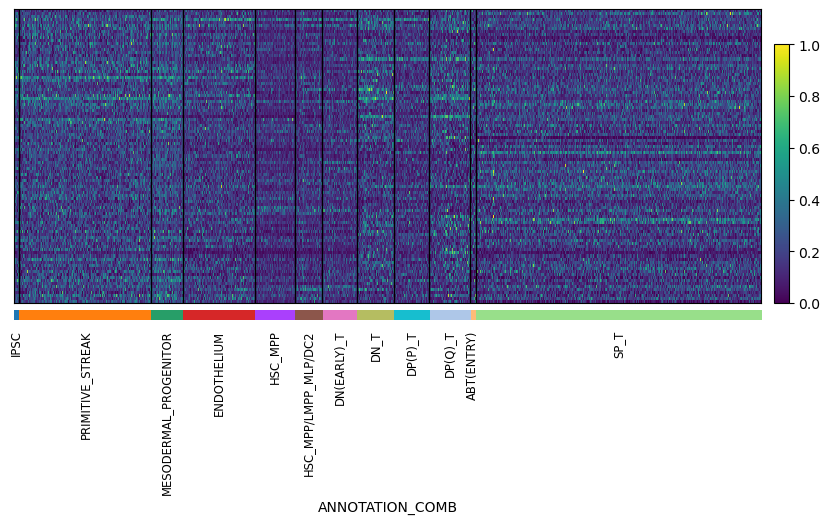

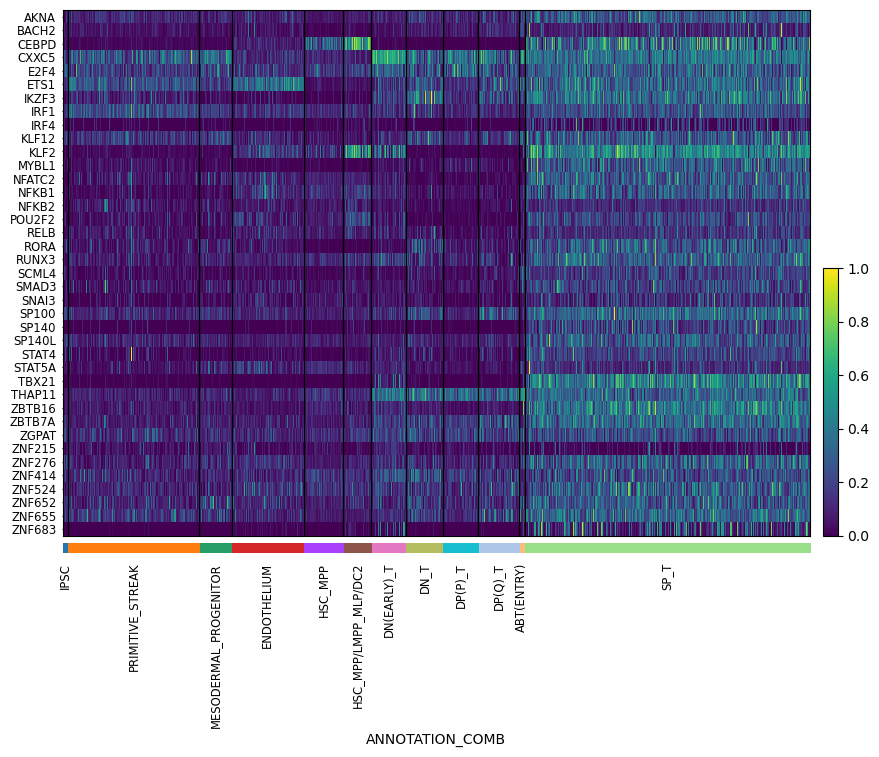

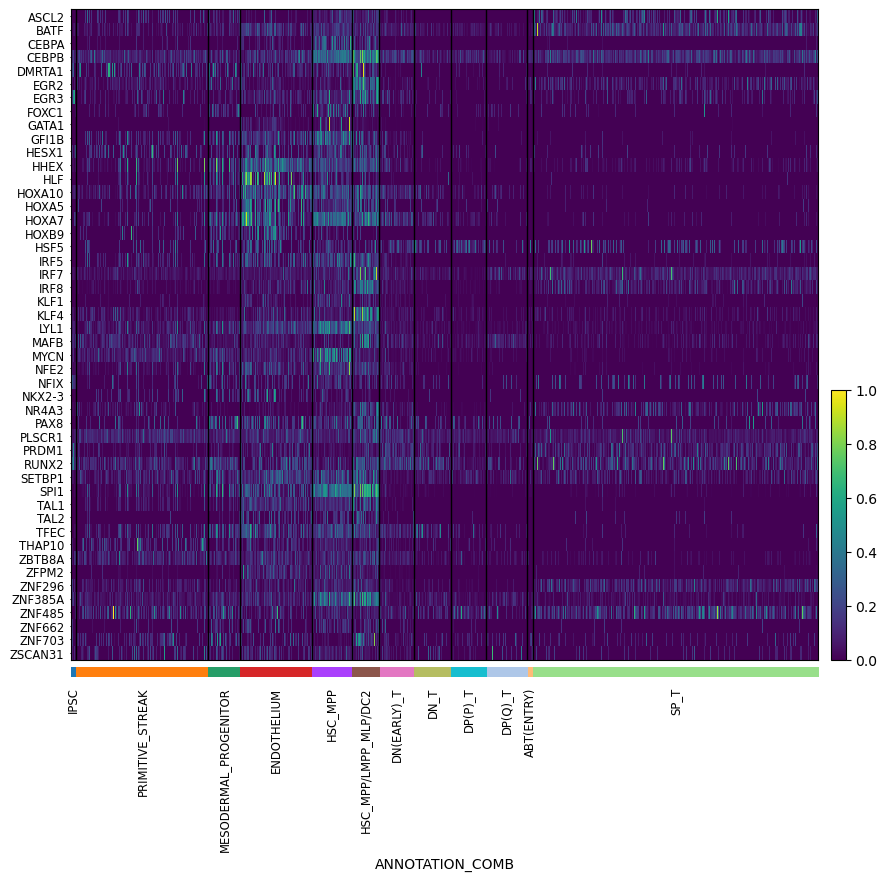

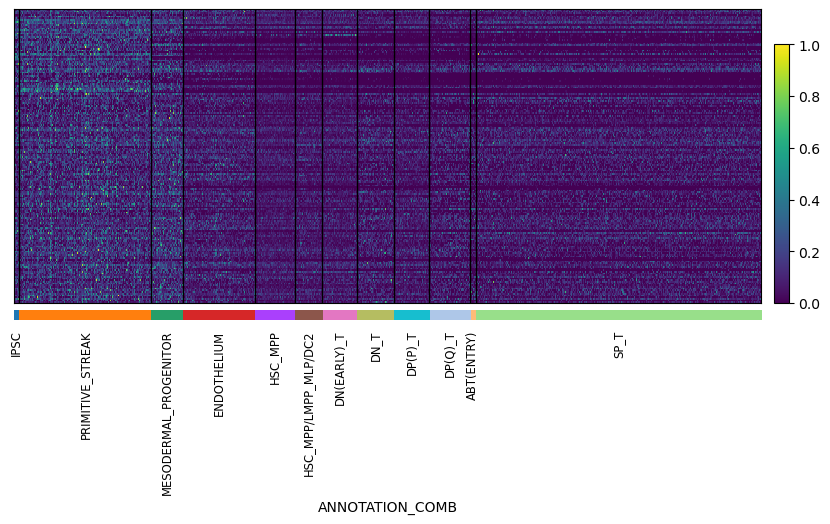

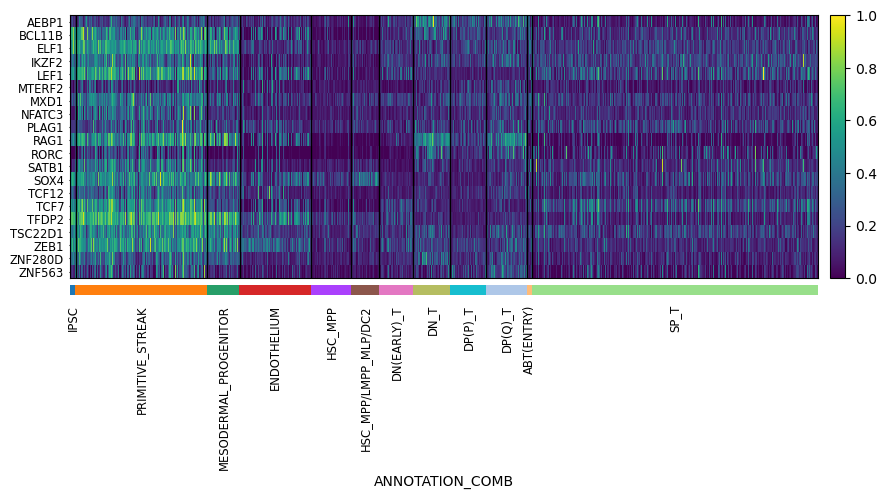

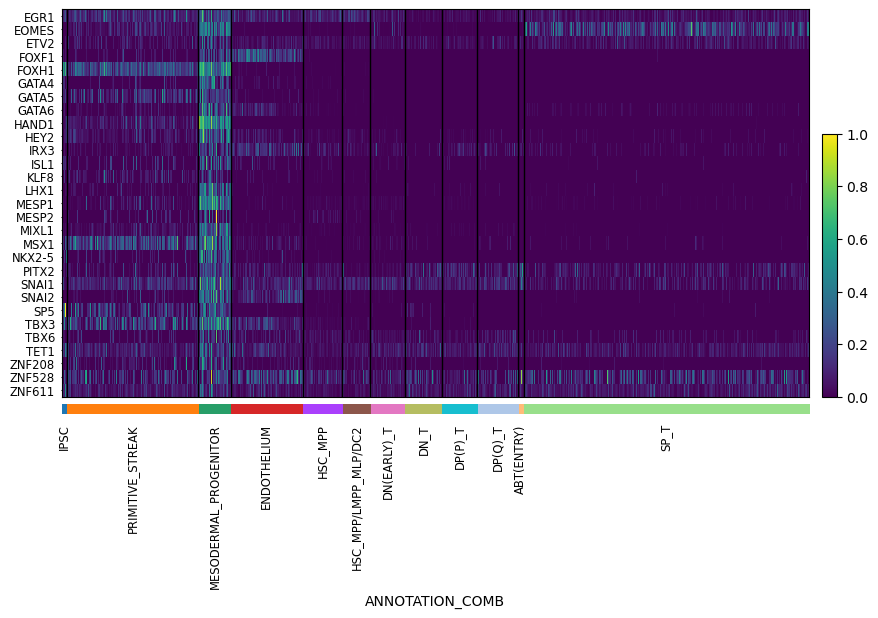

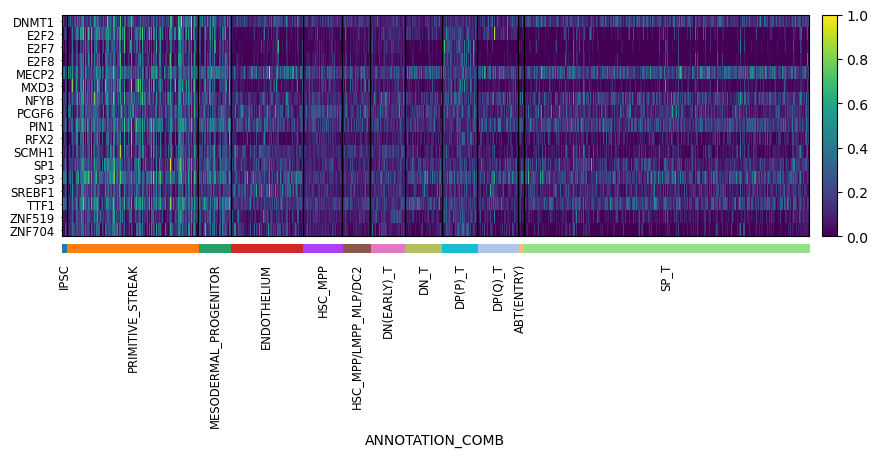

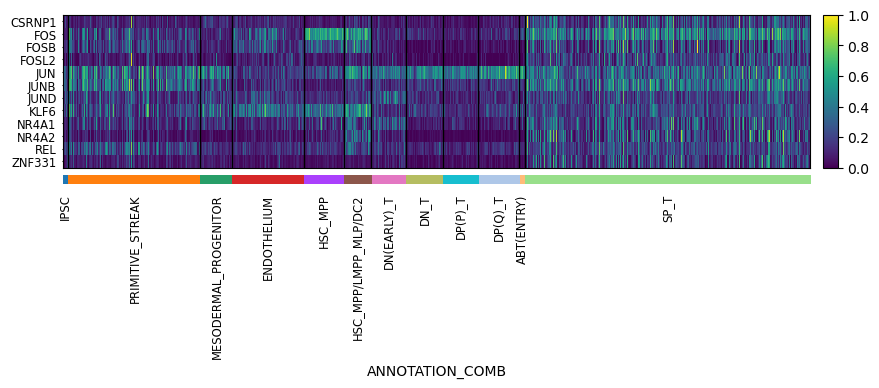

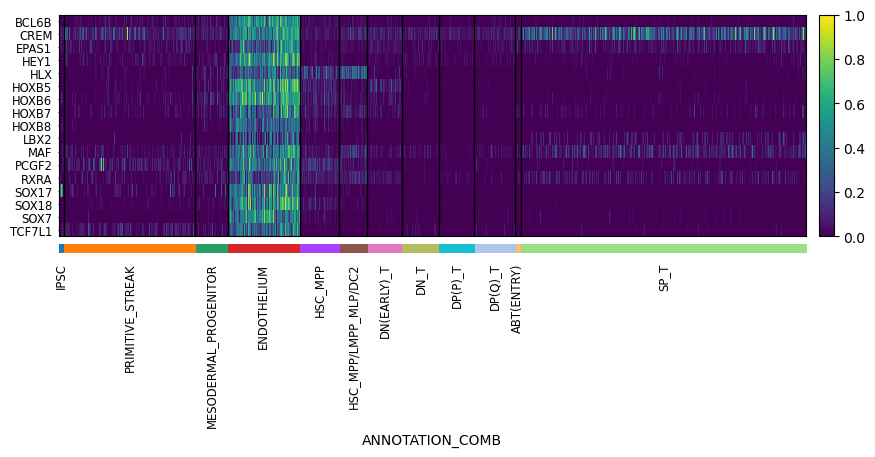

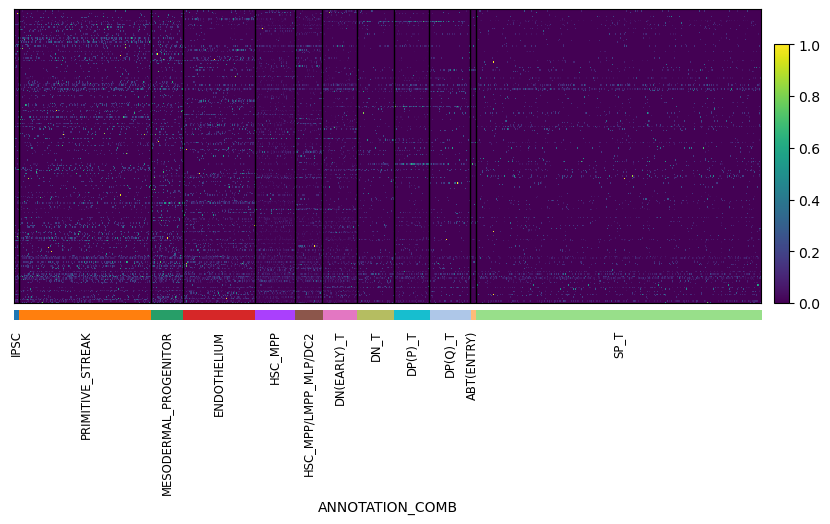

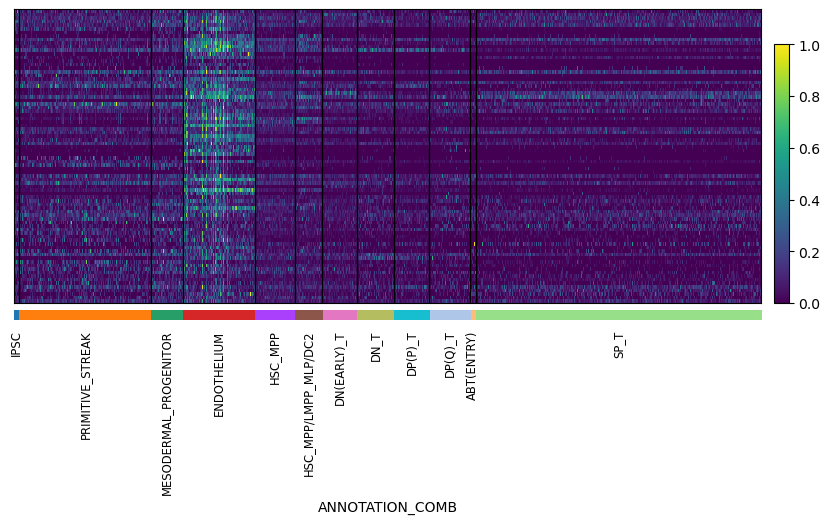

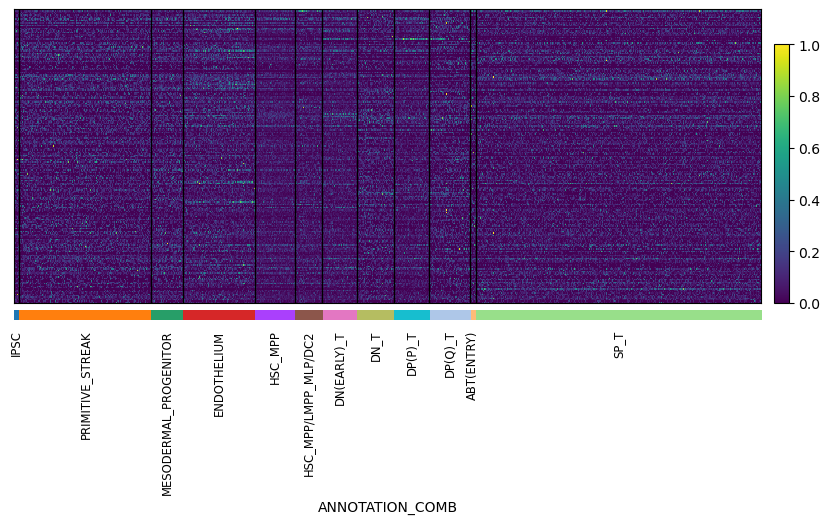

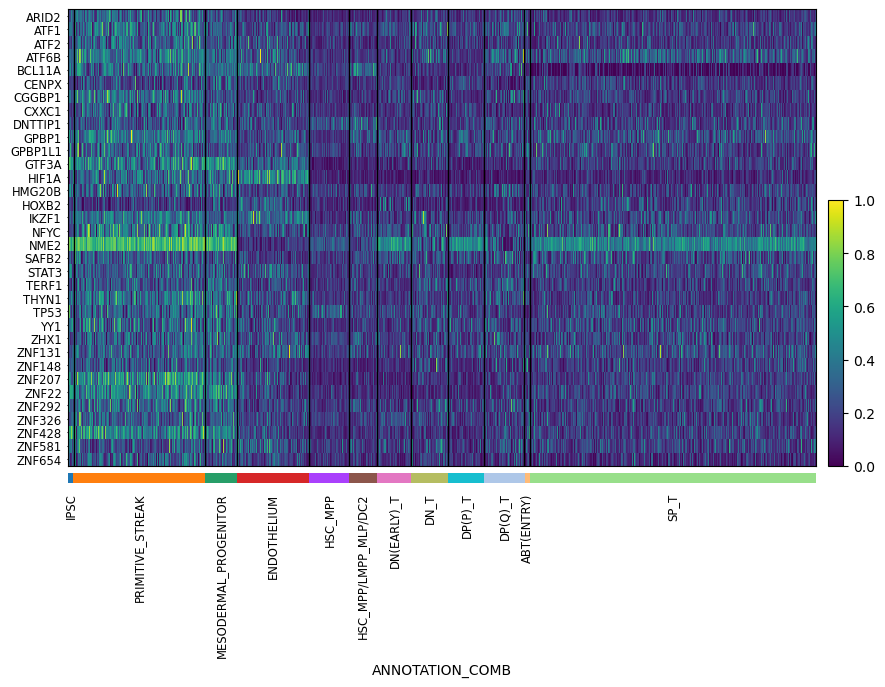

In [57]:
# plotting top genes for each NMF factor 
for cluster_id in range(len(np.unique(df['cluster_id']) )):

    genes = list(df[df['cluster_id'] == cluster_id].index)
    sc.pl.heatmap(adata_diff, genes, groupby= ANNOTATION_COLNAME, swap_axes=True, vmin =0)

# Visualising the top genes captured in each NMF factor

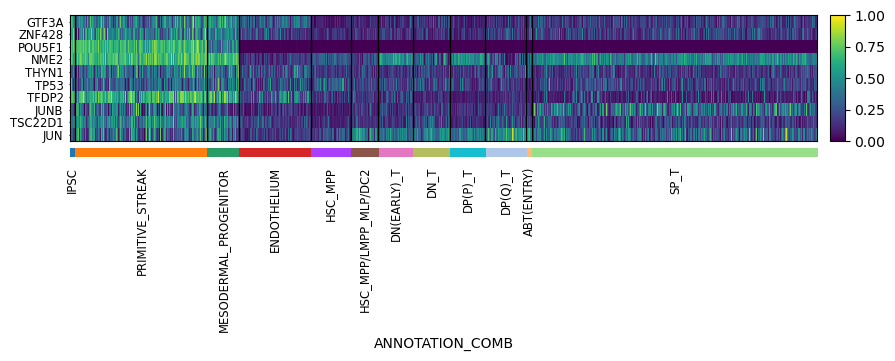

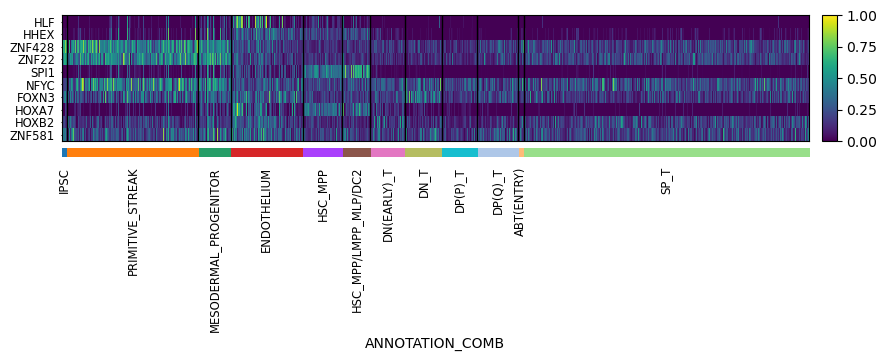

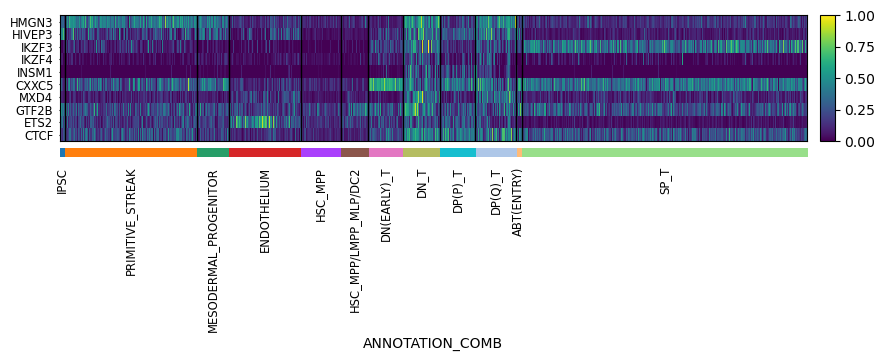

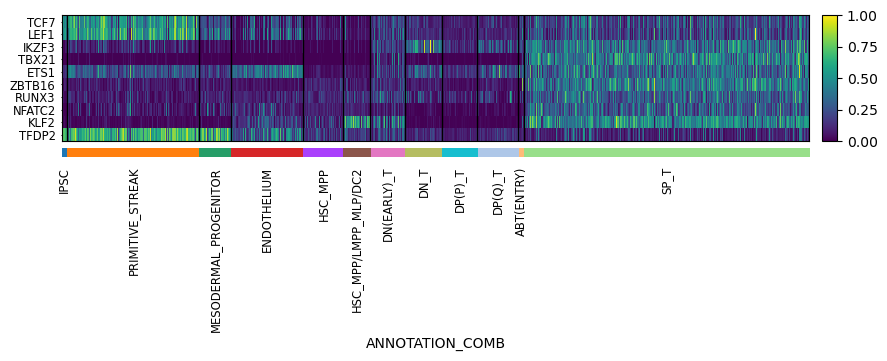

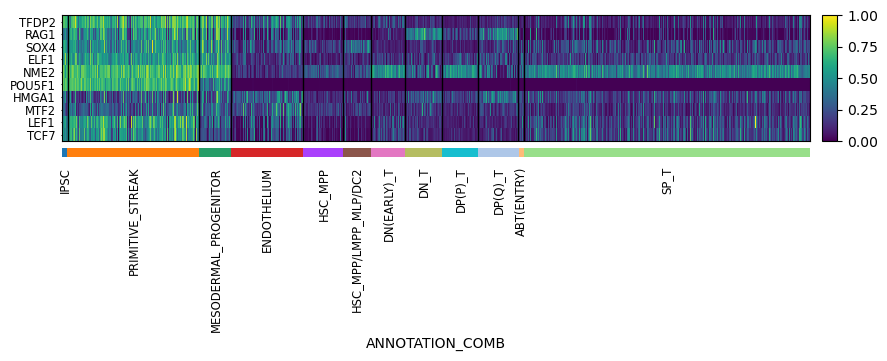

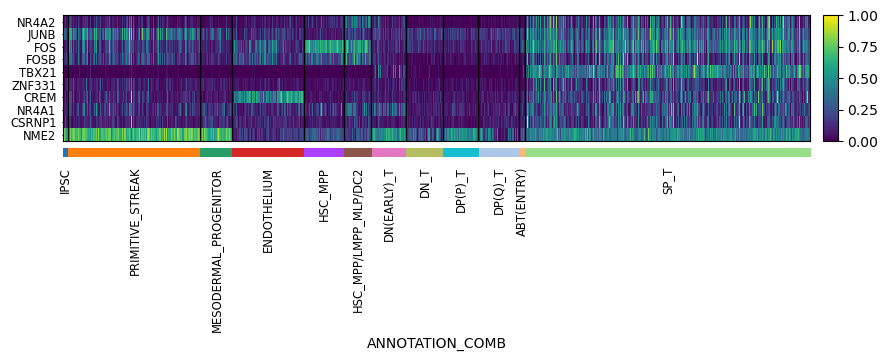

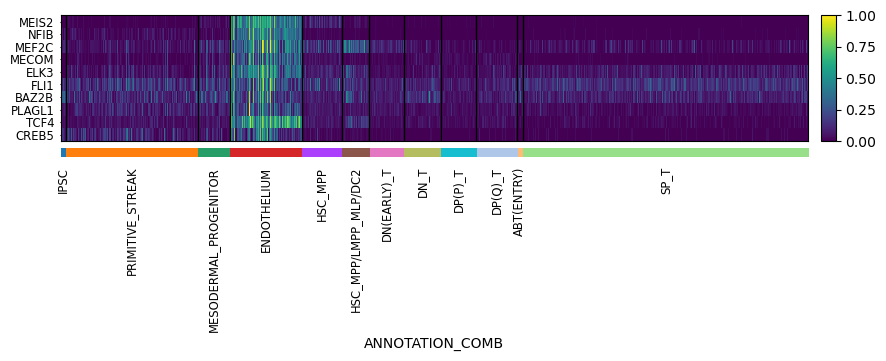

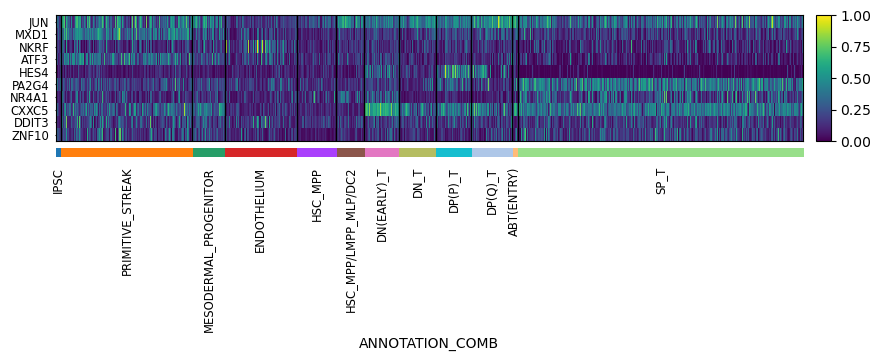

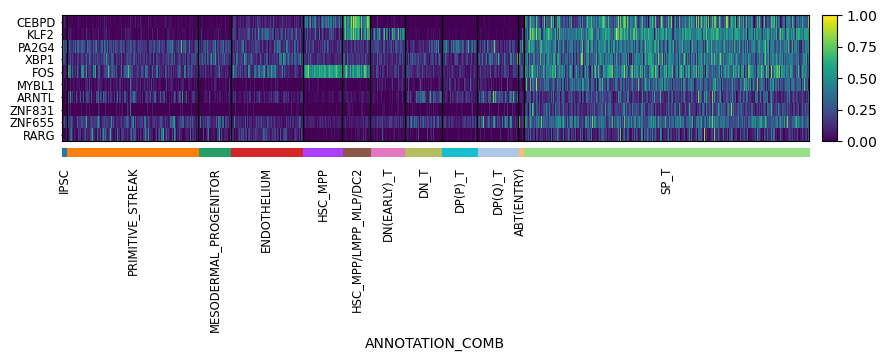

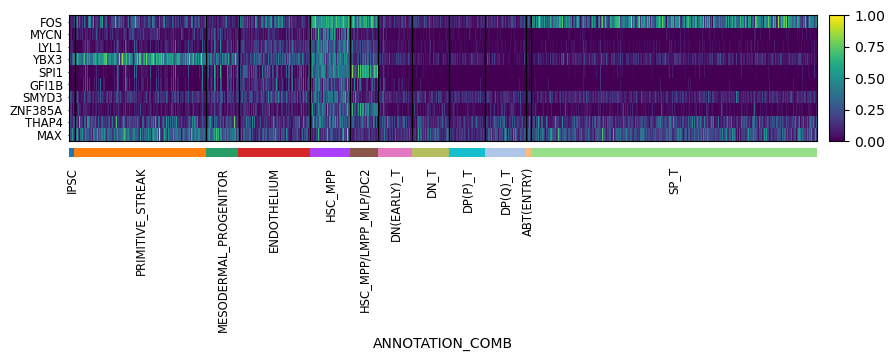

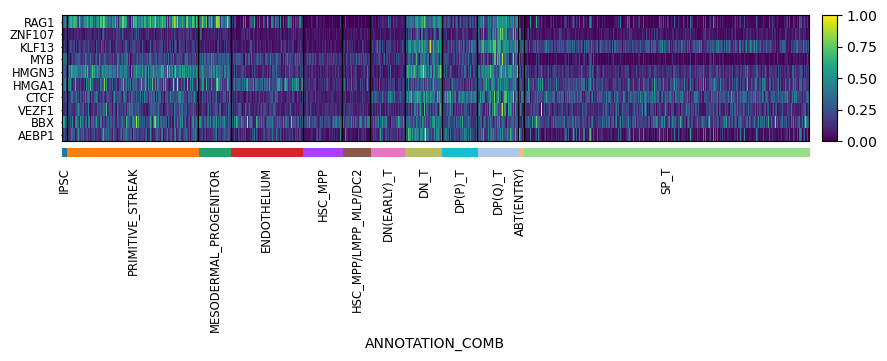

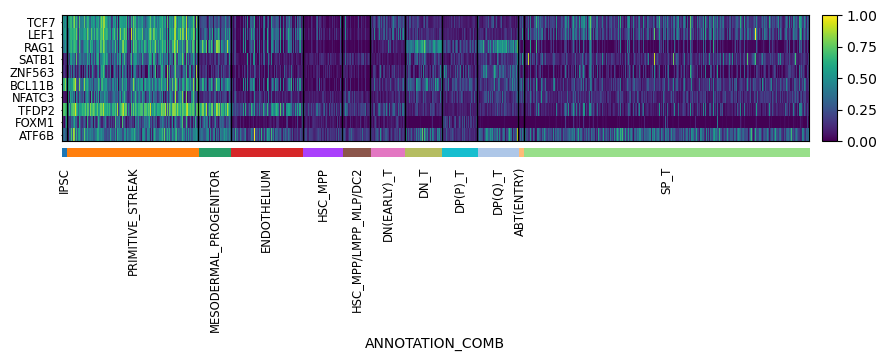

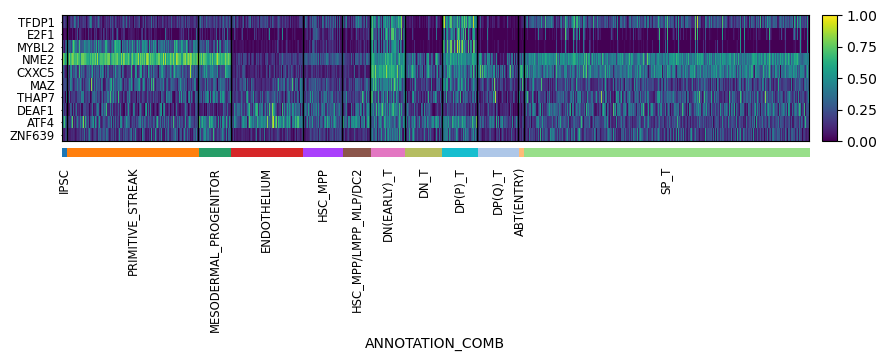

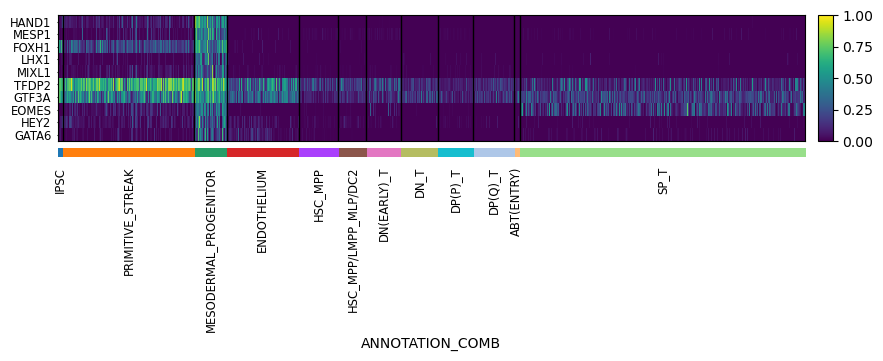

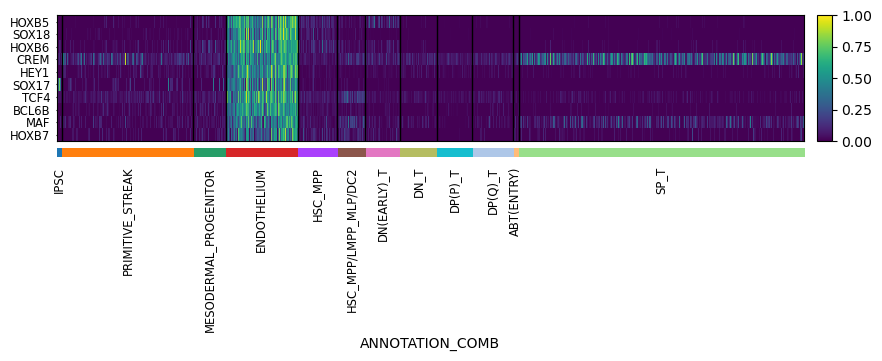

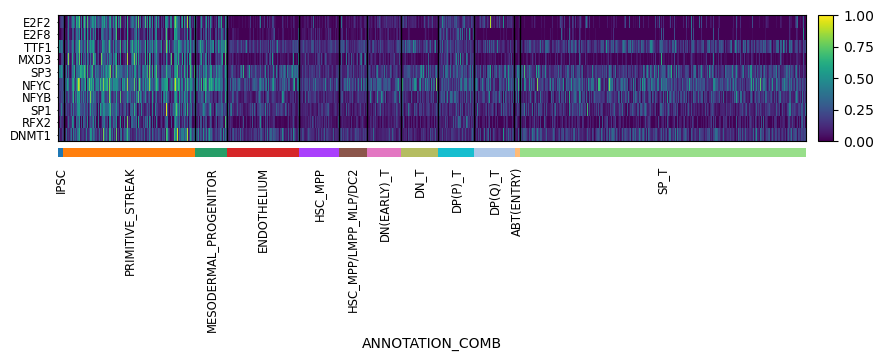

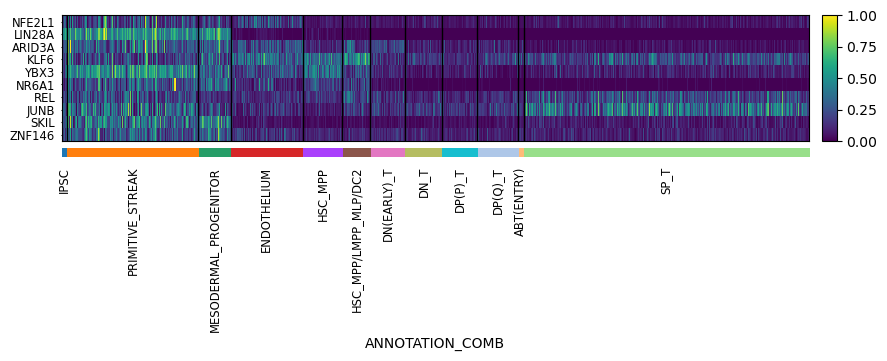

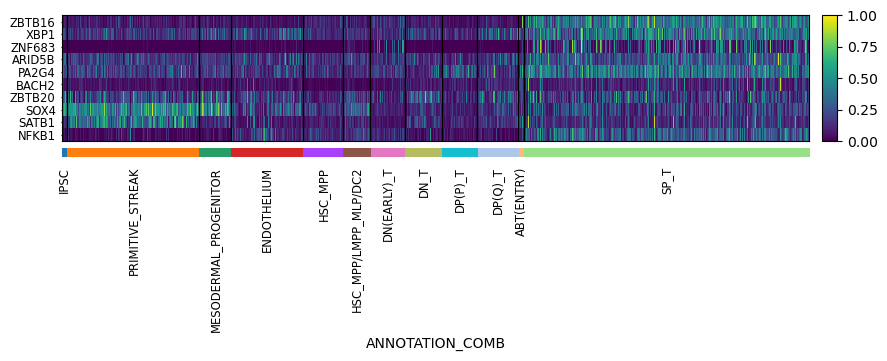

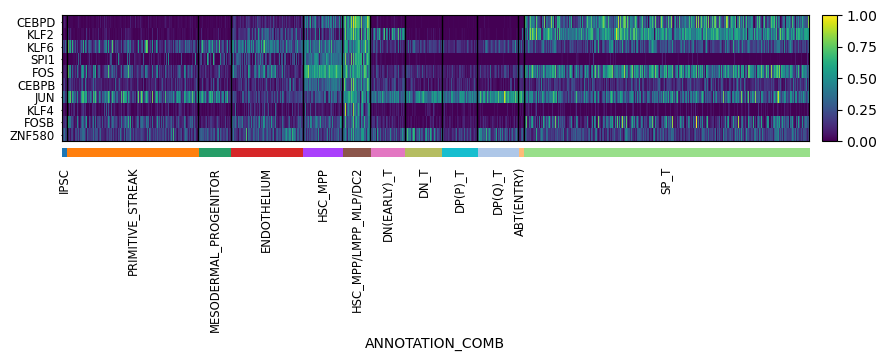

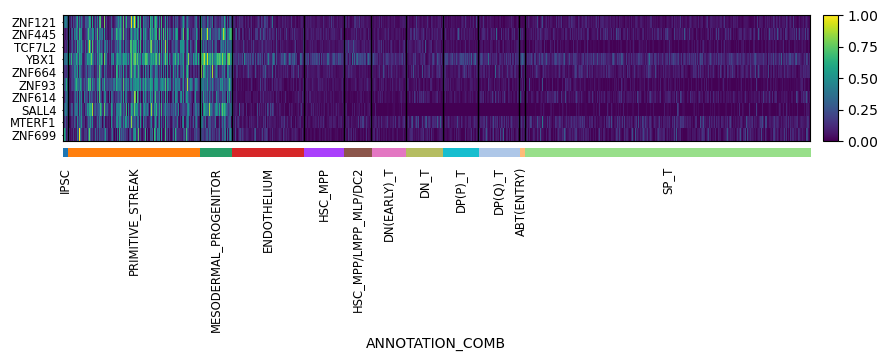

In [58]:
# plotting top genes for each NMF factor 
for factor_id in range(nmf_mat.shape[1]):
    a = nmf_mat.sort_values(by=factor_id, ascending=False)[factor_id]
    top_genes = list(a.index[0:10]) # top 10 genes
    
    sc.pl.heatmap(adata_diff, top_genes, groupby= ANNOTATION_COLNAME, swap_axes=True, vmin =0)